# Novelty Search

Novelty Search is an Evolutionary Strategy (ES) algorithm that optimises using a novelty function instead of a fitness function in a genetic algorithm. Novelty Search has shown to produce good performance for exploration in reinforcement learning. The novelty of a solution is defined by how similar the solution's behaviour is as compared to the rest of the population. The novelty score is therefore computed by its average distance from the k-nearest neighbours in the population.

In [1]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Neural Network

The application of evolutionary strategies to neural networks is neuroevolution. We use a simple neural network in PyTorch, with 2 linear layers and 2 non-linear activation functions tangent and sigmoid. The neural network serves as function mapping from observation to action of the agent. The fitness of an individual neural network is the cumulative score over one episode.

In [2]:
class Net(nn.Module):
  def __init__(self, input_size, output_size, n_hidden=16):
    super(Net, self).__init__()
    self.linear1 = nn.Linear(input_size, n_hidden, bias=True)
    self.tanh1 = nn.Tanh()
    self.linear2 = nn.Linear(n_hidden, output_size)
    self.sigmoid = nn.Sigmoid()
  def forward(self, x):
    x = self.linear1(x)
    x = self.tanh1(x)
    x = self.linear2(x)
    x = self.sigmoid(x)
    return x


def get_action(net, obs):
  return net(torch.from_numpy(obs.copy()).float()).detach().numpy().argmax()

def evaluate(net):
  obs = env.reset()
  done = False
  total_reward = 0

  while not done:
    action = get_action(net, obs)
    obs, reward, done, _ = env.step(action)
    total_reward += reward

  return total_reward

def fitness_function(net, episodes=1):
  return np.mean([evaluate(net) for _ in range(episodes)])

def compute_fitness(population):
  return np.array([fitness_function(individual) for individual in population])

def get_fittest(population, fitness_scores):
  return population[fitness_scores.argmax()]

# The Novelty Score

The novelty score is defined as the average distance of an individual $\pi$ to $k$-nearest neighbours in the population $P$, in terms of their behaviour. Therefore, the behaviour of an individual $b(\pi_i)$ must be defined. We employ a simple characterisation of a neural network's behaviour by the final observation seen by the agent in 1 evaluation. The similarity between 2 individuals' behaviours is simply the sum of squared difference between final observations:

$$similarity(\pi_i, \pi_j) = \sum||behaviour(\pi_i) - behaviour(\pi_j)||$$

The novelty of an individual with respect to the nearest $k$ neighbours of the population is defined by:

$$Novelty(\pi_i, P) = \frac{1}{|N|} \sum_{\pi_j\in N}^{k} similarity(\pi_i, \pi_j)$$

where $N$ refers to the $k$-nearest neighbours of $\pi_i$.

In [3]:
def behaviour(net):
  obs = env.reset()
  done = False
  while not done:
    action = get_action(net, obs)
    obs, reward, done, _ = env.step(action)
  return obs

def similarity(net1, net2):
    b1, b2 = behaviour(net1), behaviour(net2)
    return np.sum((b1 - b2)**2)

def compute_novelty(population, k=3):
    distances = []
    n = len(population)
    for i in range(n):
        distance_i = sorted([similarity(population[i], population[j]) for j in range(n) if i != j])[:k]
        distances.append(np.mean(distance_i))
    return distances

# Novelty Selection

Instead of selecting for the fittest individuals in a population, novelty search selects the most novel individuals by novelty score as previously defined.

In [4]:
def get_novel_subpopulation(population, novelty_scores):
  return population[novelty_scores.argmax()]

def select_most_novel(population, novelty_scores, k=0.5):
  return population[np.argsort(novelty_scores)[-int(len(population) * k):]]

# Perform Reproduction

Like in neuroevolution, reproduction among the novel parent individuals is performed by simply sampling then making a copy of the parent individual to form child individuals.

In [5]:
import copy

def perform_reproduction(subpopulation):
  num_children = population_size - len(subpopulation)
  parents = np.random.choice(subpopulation, num_children)
  return np.append(subpopulation, [copy.deepcopy(p) for p in parents], axis=0)

# Perform Mutation

Like in neuroevolution, mutation is performed by applying an additive Gaussian noise to the parameters of the neural networks.

In [6]:
from torch.nn.utils import parameters_to_vector, vector_to_parameters

def get_params(net):
  return parameters_to_vector(net.parameters())

def mutate_params(net, sigma=0.1):
    mutated_params = get_params(net) + torch.normal(0, sigma, size=get_params(net).data.shape)
    vector_to_parameters(mutated_params, net.parameters())

def perform_mutation(population, sigma=0.1):
  for individual in population:
    mutate_params(individual, sigma=0.1)
  return population

# The Novelty Search Algorithm

Algorithm:
1. Generate the initial population of individuals.
2. Repeat until convergence:
  1. Compute novelty of the population.
  2. Select the most novel individuals to form the parent subpopulation.
  3. Perform reproduction between parents to produce children.
  4. Perform mutation on the population.
    
3. Select the fittest individual of the population as the solution.

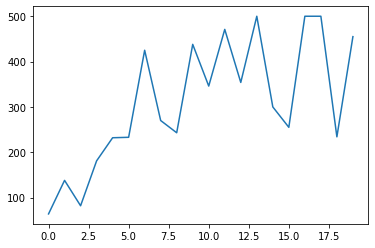

In [7]:
from tqdm.notebook import tqdm

# Novelty Search hyperparameters
population_size = 20
num_generations = 20
top_k = 0.2
mutation_sigma = 0.1
k_nearest = 3

# CartPole environment initialisation
env = gym.make('CartPole-v1')

# Neural network hyperparameters
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
n_hidden = 16

# Process 1: Generate the initial population.
population = np.array([Net(input_size, output_size, n_hidden) for _ in range(population_size)])

# Misc: Experimental tracking
scores = []
fittests = []

for i in tqdm(range(num_generations)):

  # Process 2: Compute the novelty of individuals with respect to closest neighbours in the population.
  novelty_scores = compute_novelty(population, k=k_nearest)
    
  # Process 3: Select the most novel individuals.
  novel_subpopulation = select_most_novel(population, novelty_scores, k=top_k)

  # Misc: Experimental tracking
  fitness_scores = compute_fitness(population)
  fittest = get_fittest(population, fitness_scores)
  fittests.append(fittest)
  scores.append(max(fitness_scores))

  # Process 4: Perform reproduction between parents.
  children = perform_reproduction(novel_subpopulation)
  population = perform_mutation(children, sigma=mutation_sigma)


# Misc: Experimental tracking
plt.plot(np.arange(num_generations), scores)
plt.show()

# Experiment Results

Plotting the novelty score against fitness score for the final population, we see that the novelty score that we defined is not confounded with a high fitness score.

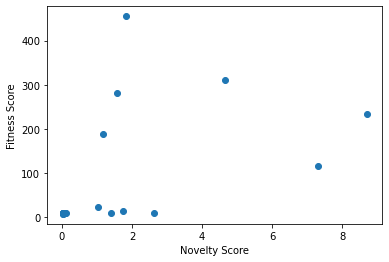

In [8]:
plt.xlabel("Novelty Score")
plt.ylabel("Fitness Score")
plt.scatter(novelty_scores, fitness_scores)
plt.show()

In [9]:
%%capture
from matplotlib.animation import FuncAnimation

def get_frames(net, episodes=3):
  for i in range(episodes):
    obs = env.reset()
    done = False
    total_reward = 0
    frames = []
    while not done:
      action = get_action(net, obs)
      obs, reward, done, _ = env.step(action)
      frames.append(env.render(mode='rgb_array'))
  env.close()
  return frames

frames = get_frames(fittest, episodes=3)
fig, ax = plt.subplots()
screen = plt.imshow(frames[i])

def animate(i):
  screen.set_data(frames[i])

ani = FuncAnimation(fig, animate, frames=np.arange(0, num_generations), interval=80, repeat=False)

In [10]:
from IPython import display as ipythondisplay
from IPython.display import HTML

HTML(ani.to_jshtml())

In [11]:
ani.save('novelty_search.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


<img src="novelty_search.gif">